# Эксперименты по классификации упаковок напитков

3 класса:
- Жестяная банка
- Картонный стакан  
- Пластиковая бутылка

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter

from fine_tuning.config import RAW_DATA_DIR, CLASS_FOLDERS, CLASS_NAMES
from fine_tuning.dataset import create_splits, BeverageDataset, train_transform, val_transform
from fine_tuning.config import TRAIN_CSV, VAL_CSV, PROCESSED_DATA_DIR

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

2025-11-07 22:14:40.686 | INFO     | fine_tuning.config:<module>:10 - PROJ_ROOT path is: /home/jaennil/dev/mlm/fine_tuning


## 1. Исследование датасета

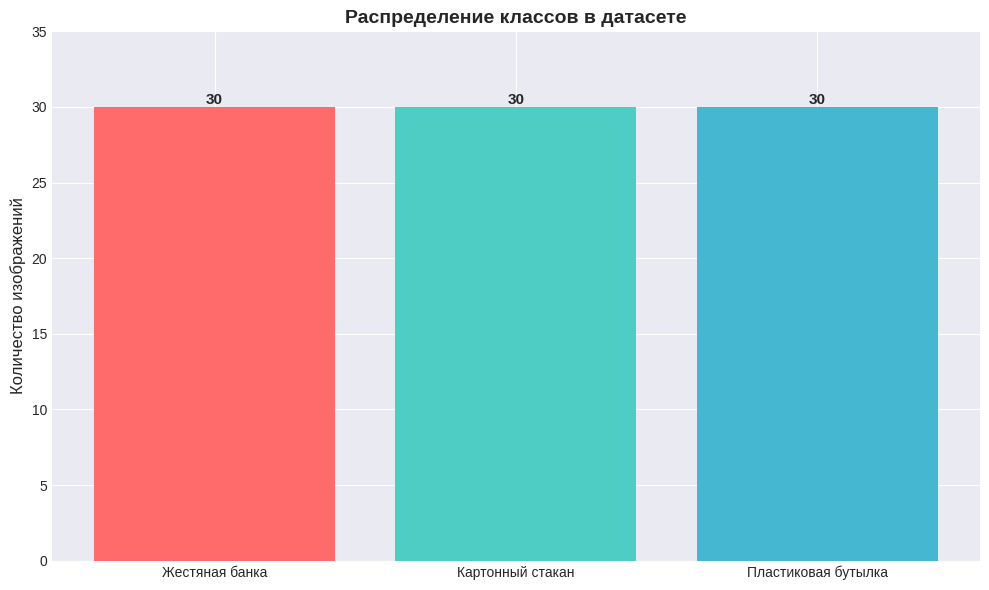


Общее количество изображений: 90


In [2]:
data_stats = {}
for folder in CLASS_FOLDERS:
    folder_path = RAW_DATA_DIR / folder
    if folder_path.exists():
        images = list(folder_path.glob("*.*"))
        images = [img for img in images if img.suffix.lower() in {".png", ".jpg", ".jpeg", ".webp"}]
        data_stats[folder] = len(images)
    else:
        data_stats[folder] = 0

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(CLASS_NAMES, data_stats.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_ylabel('Количество изображений', fontsize=12)
ax.set_title('Распределение классов в датасете', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(data_stats.values()) + 5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print()
print(f"Общее количество изображений: {sum(data_stats.values())}")

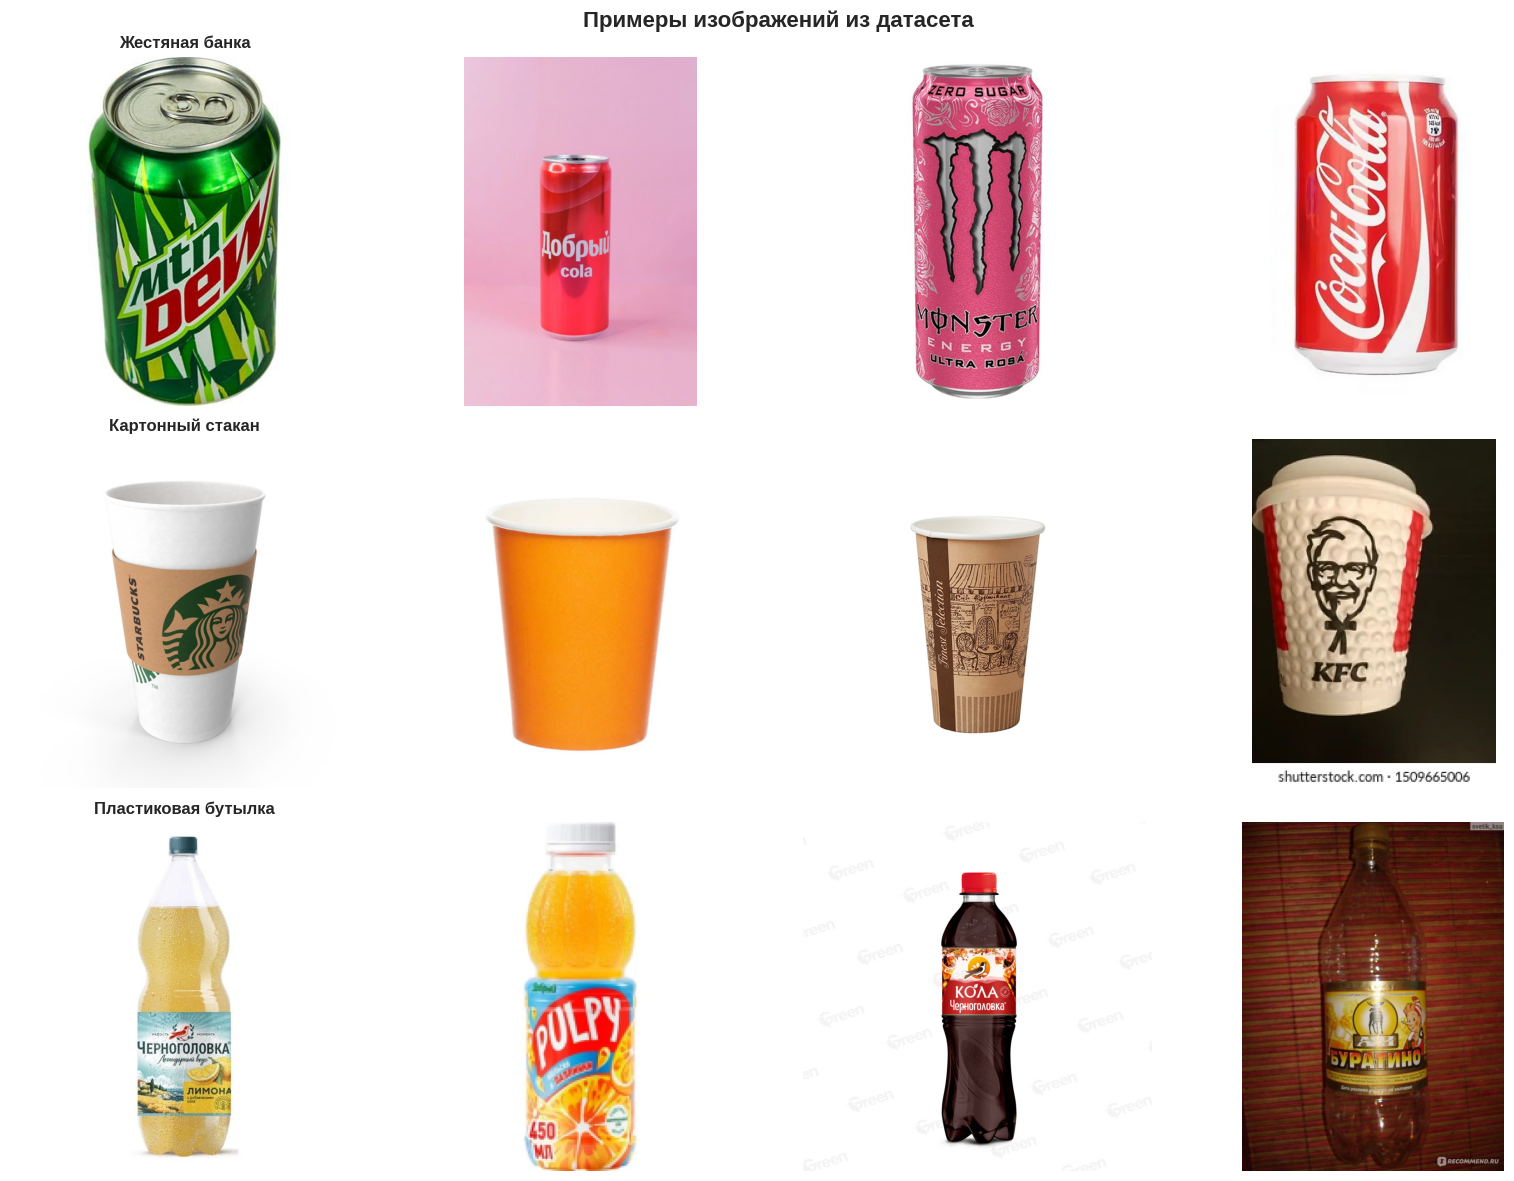

In [3]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Примеры изображений из датасета', fontsize=16, fontweight='bold')

for idx, (folder, class_name) in enumerate(zip(CLASS_FOLDERS, CLASS_NAMES)):
    folder_path = RAW_DATA_DIR / folder
    images = list(folder_path.glob("*.*"))[:4]
    
    for i, img_path in enumerate(images):
        img = Image.open(img_path).convert('RGB')
        axes[idx, i].imshow(img)
        axes[idx, i].axis('off')
        if i == 0:
            axes[idx, i].set_title(f'{class_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Разделение на train/val

Создадим разделение 80/20

In [4]:
create_splits()

train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

print(f"Тренировочная выборка: {len(train_df)} изображений")
print(f"Валидационная выборка: {len(val_df)} изображений")
print()
print(f"Распределение по классам:")
print()
print("Train:")
print(train_df['label'].value_counts().sort_index())
print()
print("Validation:")
print(val_df['label'].value_counts().sort_index())

2025-11-07 22:14:42.748 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (18)
Тренировочная выборка: 72 изображений
Валидационная выборка: 18 изображений

Распределение по классам:

Train:
label
0    24
1    24
2    24
Name: count, dtype: int64

Validation:
label
0    6
1    6
2    6
Name: count, dtype: int64


## 3. Аугментации данных

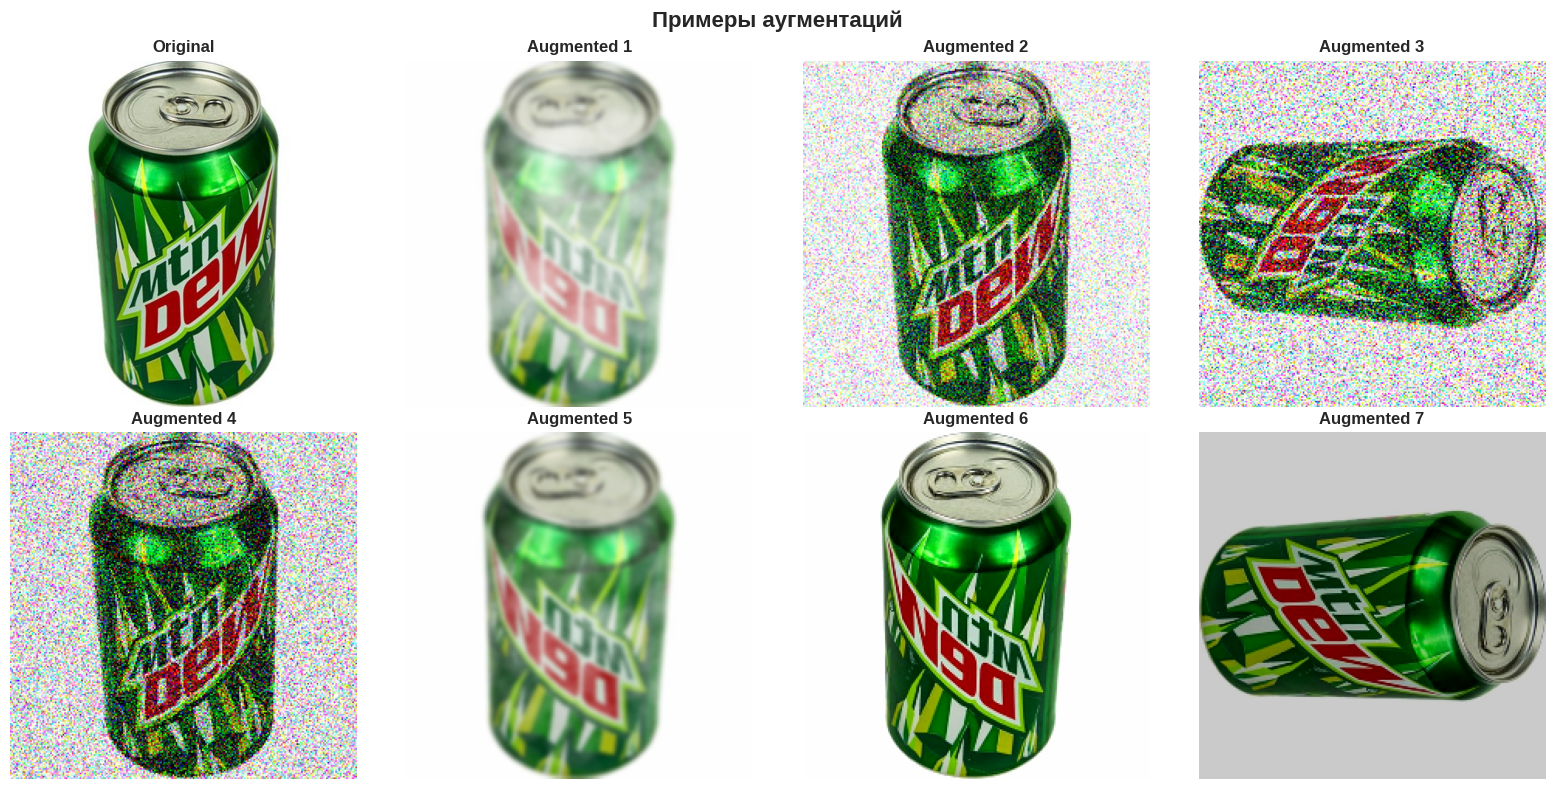

In [5]:
sample_img_path = list((RAW_DATA_DIR / "can").glob("*.png"))[0]
sample_img = np.array(Image.open(sample_img_path).convert('RGB'))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Примеры аугментаций', fontsize=16, fontweight='bold')

axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Original', fontweight='bold')
axes[0, 0].axis('off')

for i in range(7):
    augmented = train_transform(image=sample_img)['image']
    img_show = augmented.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img_show * std + mean
    img_show = np.clip(img_show, 0, 1)
    
    row = (i + 1) // 4
    col = (i + 1) % 4
    axes[row, col].imshow(img_show)
    axes[row, col].set_title(f'Augmented {i+1}', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 4. Подбор гиперпараметров

In [6]:
from fine_tuning.modeling.train import train_model
from fine_tuning.config import ConvNextConfig
import warnings
warnings.filterwarnings('ignore')

learning_rates = [1e-3, 5e-4, 1e-4]
batch_sizes = [8, 16]

quick_epochs = 8
quick_unfreeze = 4

results = []

print("начат подбор гиперпараметров")

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Testing LR: {lr}, Batch Size: {bs}")
        
        config = ConvNextConfig(
            lr=lr,
            batch_size=bs,
            epochs=quick_epochs,
            unfreeze_epoch=quick_unfreeze
        )
        
        result = train_model(config)
        
        results.append({
            'learning_rate': lr,
            'batch_size': bs, 
            'accuracy': result['best_accuracy'],
            'final_loss': result['final_loss']
        })
        
        print(f"LR: {lr}, BS: {bs} -> Accuracy: {result['best_accuracy']:.4f}, Loss: {result['final_loss']:.4f}")
        print()

param_results_df = pd.DataFrame(results)
print(param_results_df.round(4))

начат подбор гиперпараметров
Testing LR: 0.001, Batch Size: 8
2025-11-07 22:14:44.688 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=8, lr=0.001, epochs=8, freeze_backbone=True, unfreeze_epoch=4, seed=42, optimizer='Adam', scheduler='StepLR', scheduler_step=5, scheduler_gamma=0.1)
2025-11-07 22:14:44.689 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:14:44.689 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:14:44.693 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (18)
2025-11-07 22:14:44.695 | INFO     | fine_tuning.modeling.train:train_model:29 - train dataset size: 72, val dataset size: 18
2025-11-07 22:14:44.695 | INFO     | fine_tuning.modeling.train:train_model:32 - using device: cpu
2025-11-07 22:14:45.293 | INFO     | fine_tuning.modeling.train:t

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-07 22:16:16.940 | SUCCESS  | fine_tuning.modeling.train:train_model:143 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-07 22:16:16.940 | SUCCESS  | fine_tuning.modeling.train:train_model:144 - training complete. best accuracy: 1.000
LR: 0.001, BS: 8 -> Accuracy: 1.0000, Loss: 0.0585

Testing LR: 0.001, Batch Size: 16
2025-11-07 22:16:16.942 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=16, lr=0.001, epochs=8, freeze_backbone=True, unfreeze_epoch=4, seed=42, optimizer='Adam', scheduler='StepLR', scheduler_step=5, scheduler_gamma=0.1)
2025-11-07 22:16:16.943 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:16:16.943 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:16:16.947 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (1

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-07 22:17:42.278 | SUCCESS  | fine_tuning.modeling.train:train_model:143 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-07 22:17:42.278 | SUCCESS  | fine_tuning.modeling.train:train_model:144 - training complete. best accuracy: 1.000
LR: 0.001, BS: 16 -> Accuracy: 1.0000, Loss: 0.1749

Testing LR: 0.0005, Batch Size: 8
2025-11-07 22:17:42.279 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=8, lr=0.0005, epochs=8, freeze_backbone=True, unfreeze_epoch=4, seed=42, optimizer='Adam', scheduler='StepLR', scheduler_step=5, scheduler_gamma=0.1)
2025-11-07 22:17:42.281 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:17:42.281 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:17:42.285 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-07 22:19:25.042 | SUCCESS  | fine_tuning.modeling.train:train_model:143 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-07 22:19:25.042 | SUCCESS  | fine_tuning.modeling.train:train_model:144 - training complete. best accuracy: 1.000
LR: 0.0005, BS: 8 -> Accuracy: 1.0000, Loss: 0.1021

Testing LR: 0.0005, Batch Size: 16
2025-11-07 22:19:25.043 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=16, lr=0.0005, epochs=8, freeze_backbone=True, unfreeze_epoch=4, seed=42, optimizer='Adam', scheduler='StepLR', scheduler_step=5, scheduler_gamma=0.1)
2025-11-07 22:19:25.044 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:19:25.044 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:19:25.048 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-07 22:20:49.939 | SUCCESS  | fine_tuning.modeling.train:train_model:143 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-07 22:20:49.939 | SUCCESS  | fine_tuning.modeling.train:train_model:144 - training complete. best accuracy: 1.000
LR: 0.0005, BS: 16 -> Accuracy: 1.0000, Loss: 0.0521

Testing LR: 0.0001, Batch Size: 8
2025-11-07 22:20:49.940 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=8, lr=0.0001, epochs=8, freeze_backbone=True, unfreeze_epoch=4, seed=42, optimizer='Adam', scheduler='StepLR', scheduler_step=5, scheduler_gamma=0.1)
2025-11-07 22:20:49.941 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:20:49.941 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:20:49.944 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val 

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-07 22:22:17.051 | SUCCESS  | fine_tuning.modeling.train:train_model:143 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-07 22:22:17.051 | SUCCESS  | fine_tuning.modeling.train:train_model:144 - training complete. best accuracy: 1.000
LR: 0.0001, BS: 8 -> Accuracy: 1.0000, Loss: 0.1863

Testing LR: 0.0001, Batch Size: 16
2025-11-07 22:22:17.053 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=16, lr=0.0001, epochs=8, freeze_backbone=True, unfreeze_epoch=4, seed=42, optimizer='Adam', scheduler='StepLR', scheduler_step=5, scheduler_gamma=0.1)
2025-11-07 22:22:17.053 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:22:17.054 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:22:17.057 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-07 22:23:54.694 | SUCCESS  | fine_tuning.modeling.train:train_model:143 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-07 22:23:54.694 | SUCCESS  | fine_tuning.modeling.train:train_model:144 - training complete. best accuracy: 1.000
LR: 0.0001, BS: 16 -> Accuracy: 1.0000, Loss: 0.2990

   learning_rate  batch_size  accuracy  final_loss
0         0.0010           8       1.0      0.0585
1         0.0010          16       1.0      0.1749
2         0.0005           8       1.0      0.1021
3         0.0005          16       1.0      0.0521
4         0.0001           8       1.0      0.1863
5         0.0001          16       1.0      0.2990


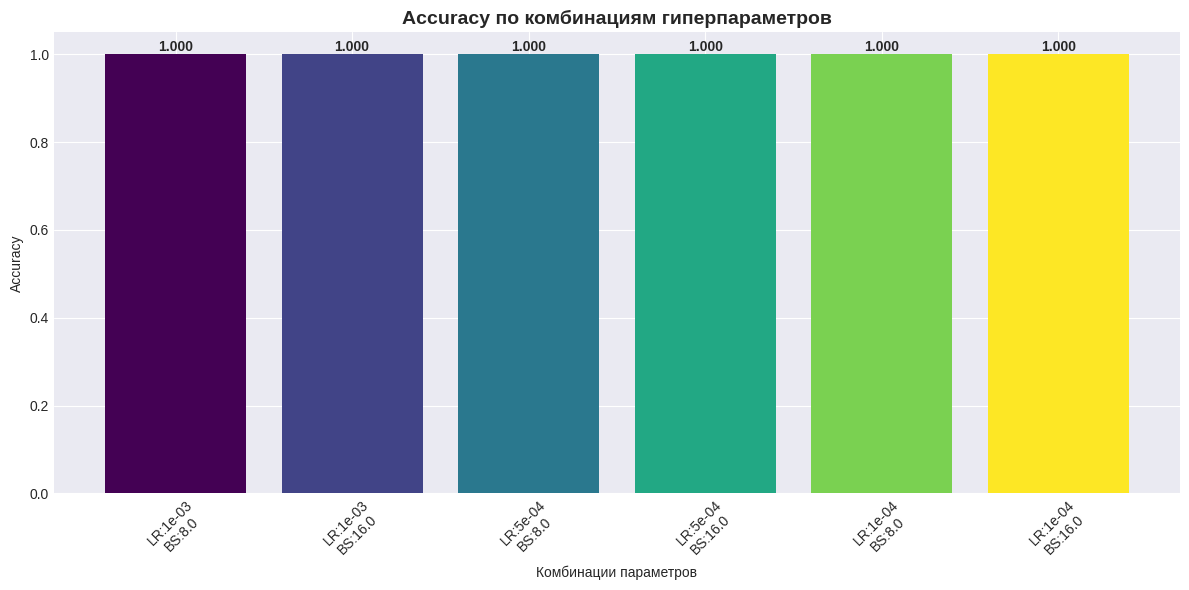

лучшая комбинация:
   Learning Rate: 0.001
   Batch Size: 8.0
   Accuracy: 1.0000

вывод: будем использовать
LR: 0.001, Batch Size: 8.0
для обучения ConvNeXt-Tiny


In [7]:
pivot_table = param_results_df.pivot_table(
    values='accuracy', 
    index='learning_rate', 
    columns='batch_size'
)

fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(param_results_df)))
bars = ax.bar(range(len(param_results_df)), param_results_df['accuracy'], color=colors)
ax.set_title('Accuracy по комбинациям гиперпараметров', fontsize=14, fontweight='bold')
ax.set_xlabel('Комбинации параметров')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(len(param_results_df)))
ax.set_xticklabels([f'LR:{row["learning_rate"]:.0e}\nBS:{row["batch_size"]}' 
                   for _, row in param_results_df.iterrows()], rotation=45)

for bar, acc in zip(bars, param_results_df['accuracy']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

best_result = param_results_df.loc[param_results_df['accuracy'].idxmax()]
print(f"лучшая комбинация:")
print(f"   Learning Rate: {best_result['learning_rate']}")
print(f"   Batch Size: {best_result['batch_size']}")
print(f"   Accuracy: {best_result['accuracy']:.4f}")

print()
print(f"вывод: будем использовать")
print(f"LR: {best_result['learning_rate']}, Batch Size: {best_result['batch_size']}")
print("для обучения ConvNeXt-Tiny")

## 5. Эксперименты с моделями

### Выбор архитектур

Сравним 2 семейства моделей:

#### 1. ResNet (Residual Networks)
- ResNet34:
    - 21.3M параметров

#### 2. ConvNeXt (Modern ConvNet)
- ConvNeXt-Tiny:
    - 28.6M параметров

In [8]:
from fine_tuning.modeling.train import train_model
from fine_tuning.config import ResNet34Config

resnet_config = ResNet34Config()
print(f"Конфигурация:")
print(f"  - Модель: {resnet_config.model_name}")
print(f"  - Batch size: {resnet_config.batch_size}")
print(f"  - Learning rate: {resnet_config.lr}")
print(f"  - Epochs: {resnet_config.epochs}")
print(f"  - Unfreeze epoch: {resnet_config.unfreeze_epoch}")

resnet_results = train_model(resnet_config)

print(f"ResNet34 обучена")
print(f"Best Accuracy: {resnet_results['best_accuracy']:.4f}")

Конфигурация:
  - Модель: resnet34
  - Batch size: 16
  - Learning rate: 0.001
  - Epochs: 12
  - Unfreeze epoch: 6
2025-11-07 22:23:54.891 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ResNet34Config(model_name='resnet34', batch_size=16, lr=0.001, epochs=12, freeze_backbone=True, unfreeze_epoch=6, seed=42, optimizer='Adam', scheduler='')
2025-11-07 22:23:54.893 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:23:54.893 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:23:54.898 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (18)
2025-11-07 22:23:54.901 | INFO     | fine_tuning.modeling.train:train_model:29 - train dataset size: 72, val dataset size: 18
2025-11-07 22:23:54.901 | INFO     | fine_tuning.modeling.train:train_model:32 - using device: cpu
2025-11-07 22:23:55.390 | INFO     | fine_tuning.modeling.t

In [9]:
from fine_tuning.config import ConvNextConfig

convnext_config = ConvNextConfig()
print(f"Конфигурация:")
print(f"  - Модель: {convnext_config.model_name}")
print(f"  - Batch size: {convnext_config.batch_size}")
print(f"  - Learning rate: {convnext_config.lr}")
print(f"  - Epochs: {convnext_config.epochs}")
print(f"  - Unfreeze epoch: {convnext_config.unfreeze_epoch}")

convnext_results = train_model(convnext_config)

print(f"ConvNeXt-Tiny обучена")
print(f"Best Accuracy: {convnext_results['best_accuracy']:.4f}")

Конфигурация:
  - Модель: convnext_tiny
  - Batch size: 8
  - Learning rate: 0.001
  - Epochs: 15
  - Unfreeze epoch: 7
2025-11-07 22:25:31.125 | INFO     | fine_tuning.modeling.train:train_model:18 - starting training with config: ConvNextConfig(model_name='convnext_tiny', batch_size=8, lr=0.001, epochs=15, freeze_backbone=True, unfreeze_epoch=7, seed=42, optimizer='Adam', scheduler='StepLR', scheduler_step=5, scheduler_gamma=0.1)
2025-11-07 22:25:31.126 | INFO     | fine_tuning.config:seed_everything:83 - seed зафиксирован: 42
2025-11-07 22:25:31.126 | INFO     | fine_tuning.modeling.train:train_model:21 - creating train/validation splits...
2025-11-07 22:25:31.130 | INFO     | fine_tuning.dataset:create_splits:67 - данные разделены на train (72), val (18)
2025-11-07 22:25:31.132 | INFO     | fine_tuning.modeling.train:train_model:29 - train dataset size: 72, val dataset size: 18
2025-11-07 22:25:31.133 | INFO     | fine_tuning.modeling.train:train_model:32 - using device: cpu
2025-1

Skipping constant folding for op SequenceEmpty with multiple outputs.
Skipping constant folding for op SequenceEmpty with multiple outputs.


2025-11-07 22:28:13.328 | SUCCESS  | fine_tuning.modeling.train:train_model:143 - ONNX сохранён: /home/jaennil/dev/mlm/fine_tuning/app/model.onnx
2025-11-07 22:28:13.328 | SUCCESS  | fine_tuning.modeling.train:train_model:144 - training complete. best accuracy: 1.000
ConvNeXt-Tiny обучена
Best Accuracy: 1.0000


       Модель Параметры  Batch Size  Learning Rate  Epochs Val Accuracy
     ResNet34     21.3M          16          0.001      12       77.78%
ConvNeXt-Tiny     28.6M           8          0.001      15      100.00%


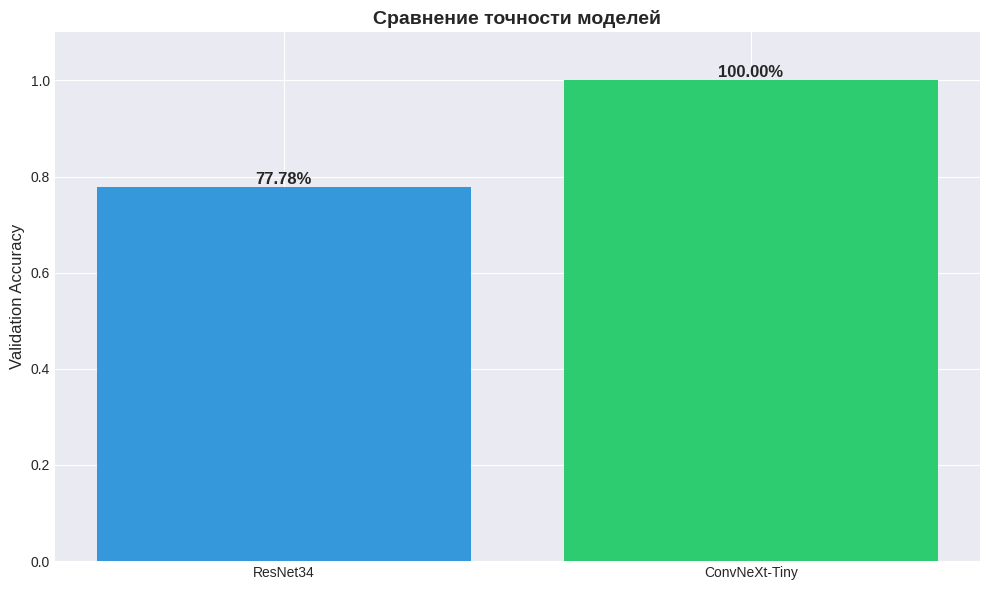

In [10]:
comparison_data = {
    'Модель': ['ResNet34', 'ConvNeXt-Tiny'],
    'Параметры': ['21.3M', '28.6M'],
    'Batch Size': [resnet_config.batch_size, convnext_config.batch_size],
    'Learning Rate': [resnet_config.lr, convnext_config.lr],
    'Epochs': [resnet_config.epochs, convnext_config.epochs],
    'Val Accuracy': [
        f"{resnet_results['best_accuracy']:.2%}",
        f"{convnext_results['best_accuracy']:.2%}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
models = ['ResNet34', 'ConvNeXt-Tiny']
accuracies = [resnet_results['best_accuracy'], convnext_results['best_accuracy']]

bars = ax.bar(models, accuracies, color=['#3498db', '#2ecc71'])
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Сравнение точности моделей', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.1)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

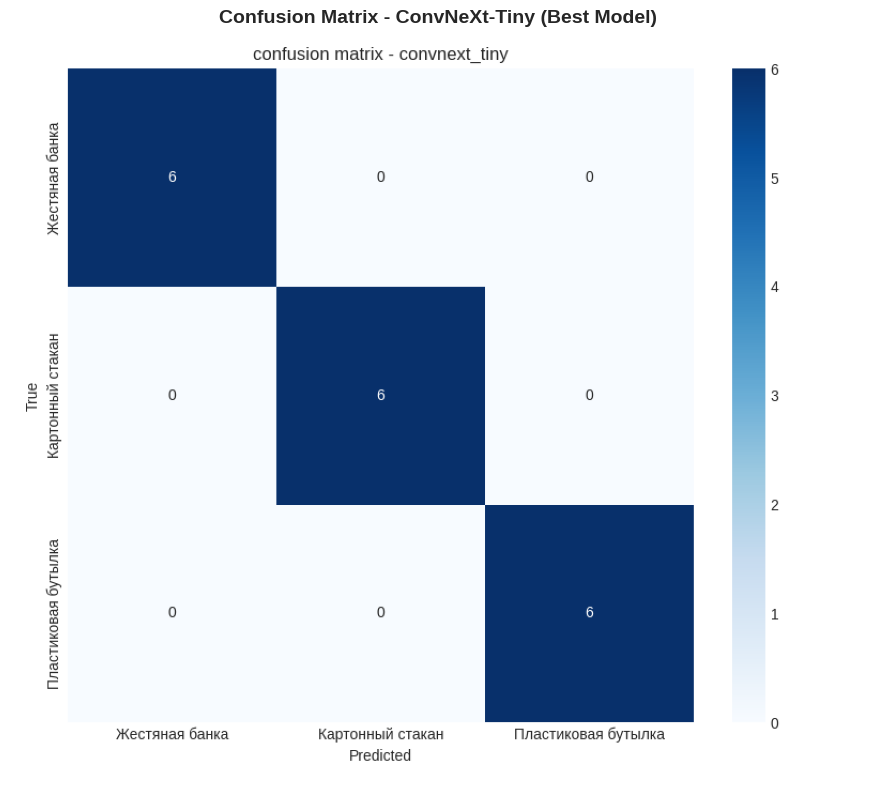

In [11]:
from PIL import Image as PILImage

cm_path = convnext_results['confusion_matrix_path']
cm_img = PILImage.open(cm_path)

plt.figure(figsize=(10, 8))
plt.imshow(cm_img)
plt.axis('off')
plt.title('Confusion Matrix - ConvNeXt-Tiny (Best Model)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

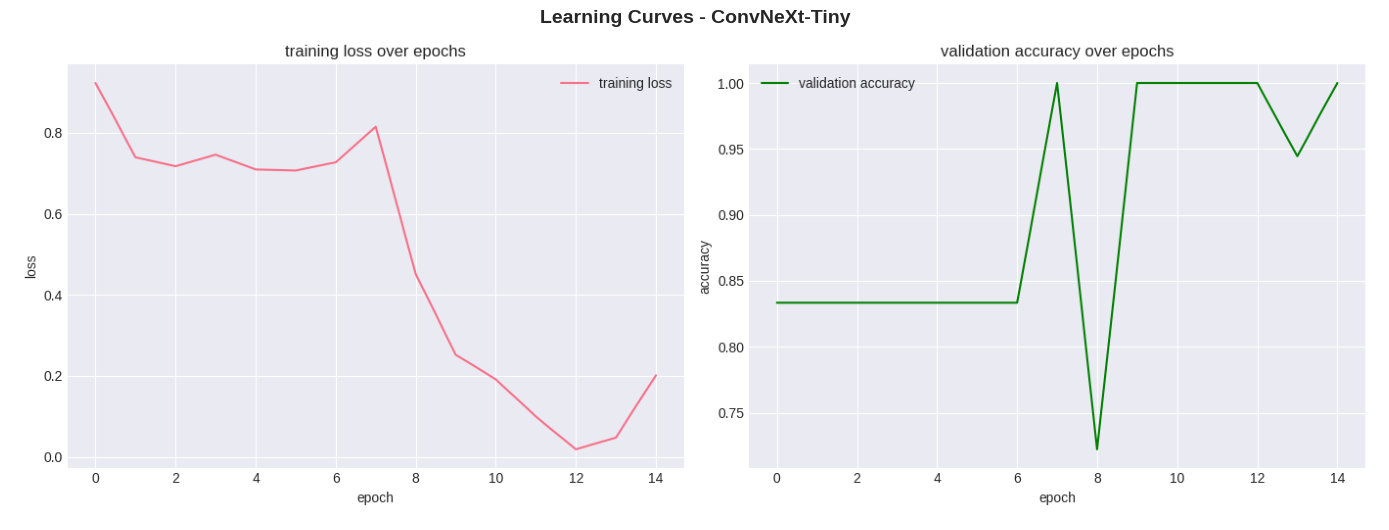

In [12]:
lc_path = convnext_results['learning_curves_path']
lc_img = PILImage.open(lc_path)

plt.figure(figsize=(14, 6))
plt.imshow(lc_img)
plt.axis('off')
plt.title('Learning Curves - ConvNeXt-Tiny', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Выводы и результаты

### Лучшая модель: ConvNeXt-Tiny

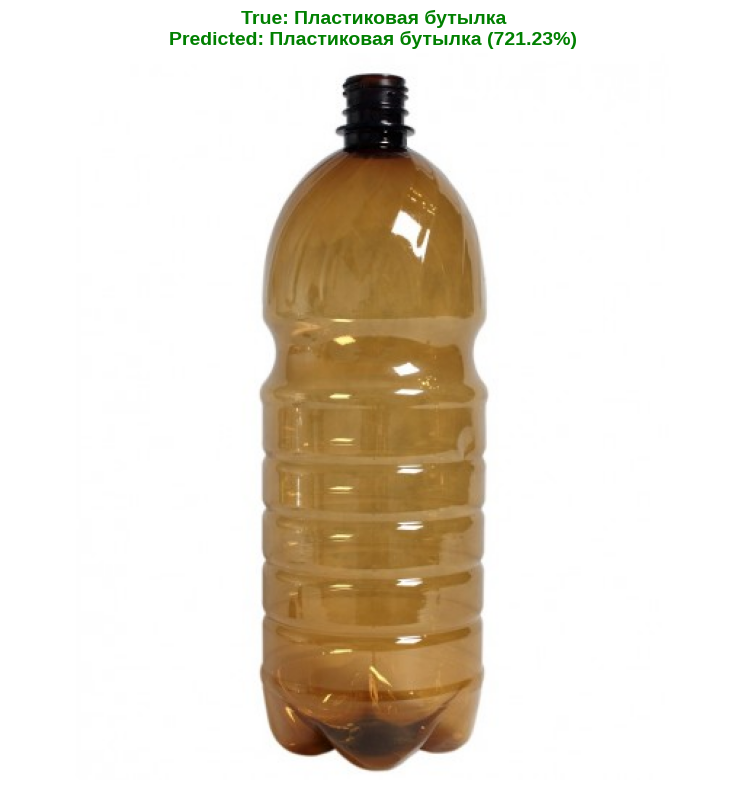

Истинный класс: Пластиковая бутылка
Предсказанный класс: Пластиковая бутылка
Уверенность: 721.23%
Правильно: да


In [13]:
import random

test_row = val_df.sample(1).iloc[0]
test_img_path = RAW_DATA_DIR / test_row['class_folder'] / test_row['filename']
true_label = CLASS_NAMES[test_row['label']]

test_img = Image.open(test_img_path).convert('RGB')

import onnxruntime as ort
session = ort.InferenceSession(str(convnext_results['onnx_path']))

test_img_array = np.array(test_img)
test_transformed = val_transform(image=test_img_array)['image'].numpy()
test_input = np.expand_dims(test_transformed, 0)

pred = session.run(None, {"input": test_input})[0]
pred_idx = np.argmax(pred)
pred_label = CLASS_NAMES[pred_idx]
confidence = pred[0][pred_idx]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(test_img)
ax.axis('off')
ax.set_title(f'True: {true_label}\nPredicted: {pred_label} ({confidence:.2%})', 
             fontsize=14, fontweight='bold', color='green' if pred_label == true_label else 'red')
plt.tight_layout()
plt.show()

print(f"Истинный класс: {true_label}")
print(f"Предсказанный класс: {pred_label}")
print(f"Уверенность: {confidence:.2%}")
print(f"Правильно: {'да' if pred_label == true_label else 'нет'}")